# FIT5212 Assignment 2
#### Student Name: Haoheng Zhu
#### StudentID: 30376467
#### Tutor: Mohammad Haquanni

# Task 1 Recommender System

In [63]:
import pandas as pd

In [64]:
train_original = pd.read_csv('train_data.csv')
validation_original = pd.read_csv('validation_data.csv')

In [65]:
train_original.head()

user_id  item_id  rating
0        0        0       1
1        0        1       1
2        0        2       1
3        0        3       1
4        0        4       1

In [66]:
train_original.rating.value_counts()

1    28449
Name: rating, dtype: int64

In [67]:
validation_original.head()

user_id  item_id  rating
0        0       43       1
1        0     1102       0
2        0      815       0
3        0      739       0
4        0     1637       0

In [68]:
validation_original.rating.value_counts()

0    221661
1      2239
Name: rating, dtype: int64

### Combine 'train_data.csv' and 'validation_data.csv' for better training dataset. This is due to there are only 1 type of value (1) in rating column in train_data.csv whereas, there are two types of value (0 and 1) in 'validation_data.csv'

In [69]:
print("There are %d rows and %d columns in 'train_data.csv' file" % (train_original.shape[0], train_original.shape[1]))

There are 28449 rows and 3 columns in 'train_data.csv' file


In [70]:
print("There are %d rows and %d columns in 'validation_data.csv' file" % (validation_original.shape[0], validation_original.shape[1]))

There are 223900 rows and 3 columns in 'validation_data.csv' file


In [71]:
combined_data = pd.concat([train_original, validation_original])

In [72]:
print("There are %d rows and %d columns in 'combined_data' dataframe." % (combined_data.shape[0], combined_data.shape[1]))

There are 252349 rows and 3 columns in 'combined_data' dataframe.


In [73]:
combined_data.reset_index(drop=True, inplace=True)

#### EDA on combined_data dataframe

In [74]:
combined_data.dtypes

user_id    int64
item_id    int64
rating     int64
dtype: object

In [75]:
combined_data.rating.value_counts()

0    221661
1     30688
Name: rating, dtype: int64

In [76]:
num_dup = 0
for i in combined_data.duplicated():
    if i == True:
        num_dup+=1

In [77]:
num_dup

4925

There are 4925 duplicates in the combined_data. We don't need these duplicates because they are redundant in this case.

In [78]:
combined_data.drop_duplicates(keep='first', inplace=True)

In [79]:
import numpy as np
# create the rating matrix r_{ui}, remember to
# subract the user and item id by 1 since
# the indices starts from 0
n_users = combined_data['user_id'].unique().shape[0]
n_items = combined_data['item_id'].unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in combined_data.itertuples(index = False):
    ratings[row.user_id - 1, row.item_id - 1] = row.rating

# compute the non-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print('dimension: ', ratings.shape)
print('sparsity: {:.2f}%'.format(sparsity))
ratings

dimension:  (2239, 2174)
sparsity: 0.63%


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.]])

### We have lots of 0 values in the dataset. This is normal because most of the times, users don't give feedbacks or interactions to most of the items. Users usually either love it or hate it when they give feedbacks or interactions to an item. Thus, sparsity of 0.6% is normal. However, with less than 1% sparsity (rule of thumb), it is very difficult to build recommender system models because the sparsity value indicates weak interactions between users and items.

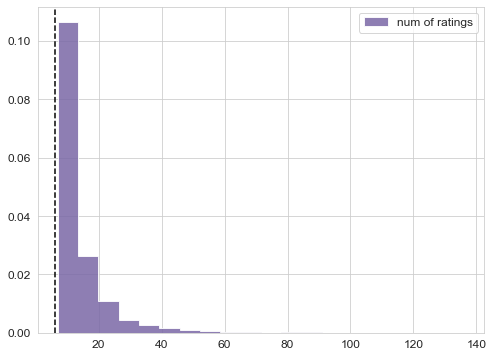

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# plot histogram of number of items that have ratings(iteraction)
plt.hist(np.sum(ratings != 0, axis = 1), histtype = 'stepfilled', bins = 20,
         alpha = 0.85, label = 'num of ratings', color = '#7A68A6', normed = True)
plt.axvline(x = 6, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

### The above histogram shows that every user has given at least 6 ratings.

#### Now split dataset into train and validation.

In [81]:
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(combined_data, test_size=0.15, random_state=19)

In [82]:
train_data.rating.value_counts()

0    184289
1     26021
Name: rating, dtype: int64

In [83]:
validation_data.rating.value_counts()

0    32447
1     4667
Name: rating, dtype: int64

In [84]:
train_data.reset_index(drop=True, inplace=True)
validation_data.reset_index(drop=True, inplace=True)

In [85]:
test_data = pd.read_csv('test_data.csv')

### From exploration, I found that the given dataset is an Implicit dataset which contains user and item interactions only. Thus, a recommender system based on collaborative filtering would be a good choice.

Although ALS and SGD(Stochastic Gradient Descent) are both good at matrix factorization when dealing with collaborative filtering (CF), SGD could be very expensive when performing on large dimension matrix. In this given dataset, the dimension would be too large for SGD. Also, usually it takes 20 iterations for ALS to diverge into the best learning result but in many cases, it would take much longer iterations for SGD to converge to the best learning result, usually more than 50 iterations. 

Thus, choosing <font color='red'>ALS</font> model from <font color='red'>implicit</font> library is reasonable approach.

Alternating least square method is an algorithm to factorize a matrix. ALS applies Collaborative Filtering for Implicit Feedback Datasets. In ALS, a user-item interaction matrix is factorized into 2 smaller matrices. The factorized matrices are user features and item features.
![](https://miro.medium.com/max/1400/1*ezY_g30VQ8MTGpDwd3z56w.png)

The Interaction matrix values usually represent specific preferences and confidence, however, in our given dataset they represent boolean value 1 and 0. With 1 being interaction and 0 being no interaction. When there is an interaction between the user and item, it is considered positive preference else negative.

![](https://miro.medium.com/max/772/1*LB7XYsLQ5sHWCffrr4XTpA.png)

The idea of Confidence is the Value we give to each type of interaction. Usually, the stronger the interaction event, the higher the confidence value is assigned. In our case, we only have two type of events (interaction and no interaction).

![](https://miro.medium.com/max/205/1*fcx5Y2fkeQeCpghrDvJZFw.png)

Here, r is the interaction and $\alpha$ is the value assigned to the type of interaction. Thus, higher the interaction value or the $\alpha$, higher the confidence.

In [86]:
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy.sparse as sparse
import numpy as np

In [87]:
sparse_item_person = sparse.csr_matrix((train_data.rating,(train_data.item_id, train_data.user_id)))

In [88]:
sparse_person_item = sparse.csr_matrix((train_data.rating,(train_data.user_id, train_data.item_id)))

In [89]:
sparse_item_person

<2174x2239 sparse matrix of type '<class 'numpy.int64'>'
	with 210310 stored elements in Compressed Sparse Row format>

In [90]:
sparse_person_item

<2239x2174 sparse matrix of type '<class 'numpy.int64'>'
	with 210310 stored elements in Compressed Sparse Row format>

Matrix Factorization:

The user-item interaction matrix can be decomposed into R = U * V

![](http://ethen8181.github.io/machine-learning/recsys/img/matrix_factorization.png)

Matrix factorization assumes that:

* Each user can be described by  d  features. For example, feature 1 might be a referring to how much each user likes disney movies.
* Each item, movie in this case, can be described by an analogous set of  d  features.

ALS factors the user to item matrix R into the user-to-feature matrix U and the item-to-feature matrix V: It runs the ALS algorithm in a parallel fashion.  The ALS algorithm should uncover the latent factors that explain the observed user to item ratings and tries to find optimal factor weights to minimize the least squares between predicted and actual ratings.

# ALS Model Fitting

Since we only have two types of interactions ( interaction and no interaction), the alpha value we assign to should be high in order to distinguish the two extreme types.

In [91]:
alpha = 28 #The rate in which we'll increase our confidence in a preference with more interactions.
data = (sparse_item_person * alpha).astype('double')

In [92]:
data[1,:].todense()

matrix([[28.,  0.,  0., ...,  0.,  0.,  0.]])

In [93]:
#fit the model
model = implicit.als.AlternatingLeastSquares(factors=6, regularization=0.1, iterations=50)
model.fit(data)

The ALS algorithm needs some tuning because we don't know the exact number of latent factors (latent features). We don't know these beforehand, thus, after obtaining the fitted model, we have to tune the hyperparameters in order to get the best accuracy or NDCG score.

After training the model, we learned from the two smaller matrices (user-fea, item-fea). Next step we do is to perform a dot multiplication of the matrices and the end result would be the prediction of interation or rating.
\begin{align}
\hat r_{ui} &= \textbf{x}_{u} \textbf{y}_{i}^{T} = \sum\limits_{d} x_{ud}y_{di}
\end{align}

Here $\hat r_{ui}$ is the prediction of rating, whereas $r_{ui}$ is the true rating.

We want to minimize the objective (Loss) function which can be expressed as follows:



\begin{align}
L &= \sum\limits_{u,i \in S}( r_{ui} - \textbf{x}_{u} \textbf{y}_{i}^{T} )^{2} + \lambda \big( \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \sum\limits_{i} \left\Vert \textbf{y}_{i} \right\Vert^{2} \big)
\end{align}

We want to calculate the sum of square of the difference between all ratings in our dataset ( S ) and our predictions. Here $\lambda$ is the regularization (weight) value we assign to the latent features that we need to tune to avoid overfitting. 

# Finding Similar Items
Try to find top 10 similar items for given item_id.

- Get the person and item vectors from our trained model.
- Calculate the vector norms.
- Calculate the similarity score.
- Get the top 10 items.
- Create a list of item-score tuples of most similar items with this item.

In [94]:
item_id = 10
n_similar = 10

person_vecs = model.user_factors
item_vecs = model.item_factors

item_norms = np.sqrt((item_vecs * item_vecs).sum(axis=1))

scores = item_vecs.dot(item_vecs[item_id]) / item_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / item_norms[item_id]), key=lambda x: -x[1])



In [95]:
similar

[(10, 1.0),
 (38, 0.9941223),
 (1046, 0.98328763),
 (1466, 0.9669865),
 (1197, 0.9629965),
 (1878, 0.96146977),
 (514, 0.9601126),
 (1438, 0.9578278),
 (1834, 0.95741314),
 (1196, 0.9570983)]

In [96]:
for content in similar:
    idx, score = content
    print("item_id: %d and similarity score is: %s" % (idx, str(score)))

item_id: 10 and similarity score is: 1.0
item_id: 38 and similarity score is: 0.9941223
item_id: 1046 and similarity score is: 0.98328763
item_id: 1466 and similarity score is: 0.9669865
item_id: 1197 and similarity score is: 0.9629965
item_id: 1878 and similarity score is: 0.96146977
item_id: 514 and similarity score is: 0.9601126
item_id: 1438 and similarity score is: 0.9578278
item_id: 1834 and similarity score is: 0.95741314
item_id: 1196 and similarity score is: 0.9570983


# Recommend Items to Users
In the following, we will return the top 10 recommendations chosen based on the person / content vectors for contents never interacted with for any given user. The flow of the function is as follows:

- Get the interactions score from the sparse person item matrix.
- Add 1 to everything, so that articles with no interaction yet become equal to 1.
- Make items already interacted zero.
- Get dot product of person vector and all content vectors.
- Scale this recommendation vector between 0 and 1.
- Item already interacted have their recommendation multiplied by zero.
- Sort the indices of the content into order of best recommendations.
- Start empty list to store items and scores.
- Append items and scores to the list.
- Get the trained person and item vectors. We convert them to csr matrices.
- Create recommendations for person with id 5.

In [97]:
def recommend(person_id, sparse_user_item, person_vecs, item_vecs, num_contents=2174):
    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_user_item[person_id,:].toarray()
    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1
    # Make articles already interacted zero
    person_interactions[person_interactions > 1] = 0
    # Get dot product of person vector and all content vectors
    rec_vector = person_vecs[person_id,:].dot(item_vecs.T).toarray()
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # Content already interacted have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    # Start empty list to store titles and scores
    items = []
    scores = []

    for idx in content_idx:
        # Append titles and scores to the list
        items.append(train_data.item_id.loc[train_data.item_id == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'item_id': items, 'score': scores})

    return recommendations
    
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = sparse.csr_matrix(model.user_factors)
item_vecs = sparse.csr_matrix(model.item_factors)

# Create recommendations for person with id 5
person_id = 5

recommendations = recommend(person_id, sparse_person_item, person_vecs, item_vecs)

print(recommendations)

      item_id     score
0         241  1.000000
1         648  0.994998
2         555  0.939134
3          34  0.938648
4         455  0.909505
...       ...       ...
2169      127  0.000000
2170      918  0.000000
2171      128  0.000000
2172      129  0.000000
2173      118  0.000000

[2174 rows x 2 columns]


# predict on test_data

I first tried to create a dictionary to recommend all the 2174 items to all users, then apply the score to test_data and sort the score then drop the score column. But this way is too time consuming. Each time I run it’ll take 30 minutes to calculate. Later I found the built-in rank_items method inherited from implicit.als module, such method takes user_id, person-item sparce matrix, list of item_id as inputs, then outputs corresponding scores. But my dataframe returns item_id as an integer, hence I wrote a num_list function to convert any number into a list of that number in order to use rank_items mothod. By doing this, I was able to recommend items to the test_data based on the scores.

In [98]:
test_data

user_id  item_id
0             0     2158
1             0     2113
2             0     2070
3             0     2026
4             0     1948
...         ...      ...
223895     2238       53
223896     2238       37
223897     2238       27
223898     2238       18
223899     2238       18

[223900 rows x 2 columns]

#### Define a function to convert num to a list of that num. This is to reuse 'rank_items' method from ALS library.

In [99]:
def num_list(num):
    numList = []
    numList.append(num)
    return numList
    

In [100]:
new_test = test_data
new_test['score'] = new_test.apply(lambda row: model.rank_items(row['user_id'], sparse_person_item, num_list(row.item_id))[0][1],axis=1)

In [101]:
new_test = new_test.sort_values(by=['user_id', 'score'], ascending=[1,0])

In [102]:
new_test = new_test.drop(columns=['score'])

In [ ]:
new_test.to_csv('30376467.csv', index=False)

When tuning my ALS model, I first tried factors = 20, regularization = 0.1, iteration = 50, alpha = 15 and received accuracy = 14.8%. Then I tried larger factors (40) since we have 150 features for both item and user, but received a much lower accuracy. After that I tried smaller factors (10) and received an improved accuracy, so I gradually came to a combination of factors = 6, regularization = 0.1, iteration = 50, alpha = 28 and received 20.189% accuracy on Kaggle.

The parameters I've tried are: 

factors = 20
regularization = 0.1
iteration = 50
alpha = 15
accuracy = 14.8%

factors = 40
regularization = 0.01
iteration = 50
alpha = 15
accuracy = 12.4%

factors = 10
regularization = 0.1
iteration = 50
alpha = 15
accuracy = 15.75%

factors = 10
regularization = 0.1
iteration = 50
alpha = 40
accuracy = 15.8%

factors = 5
regularization = 0.1
iteration = 50
alpha = 40
accuracy = 19.3%

..........

factors = 6
regularization = 0.1
iteration = 50
alpha = 28
accuracy = 20.189%

# Task 2

In [1]:
import dgl
import networkx as nx
import torch
import dgl.function as fn

Using backend: pytorch


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

edge_file = open('../A2 graph data/A2 graph data/adjedges.txt', 'r')
edge_content = edge_file.readlines()
edge_file.close

edge_stripped = []
for line in edge_content:
    edge_stripped.append(line.strip())
    
edge_pre_list=[]
for ele in edge_stripped:
    sub = ele.split(', ')
    edge_pre_list.append(sub)

In [4]:
def str_list(string):
    strList = []
    strList.append(string)
    return strList

edge_full_list = []
for lists in edge_pre_list:
    for ele in lists:
        if ' ' in ele:
            edge_full_list.append(ele.split())
        else:
            edge_full_list.append(str_list(ele))

Create a edge_list that stores edge information in a fashion that favors DGL library. Edge_list would look like [(1,0),(1,2)]

In [5]:
edge_list_DGL = []
node_without_edge_list = []

for ele in edge_full_list:
    if len(ele) > 1:
        for i in range(len(ele)-1):
            edge_list_DGL.append((ele[0], ele[i+1]))
    elif len(ele) == 1:
        node_without_edge_list.append(ele[0])

In [6]:
edge_list_DGL

[('38902949', '38998399'),
 ('33450563', '26547200'),
 ('57470294', '20968604'),
 ('54791317', '9564967'),
 ('54791317', '14589786'),
 ('4289706', '48119811'),
 ('67315895', '47074959'),
 ('67315895', '36354718'),
 ('67315895', '38323242'),
 ('67315895', '40935482'),
 ('67315895', '77107975'),
 ('67315895', '38994139'),
 ('67315895', '48871207'),
 ('67315895', '75049959'),
 ('67315895', '68339148'),
 ('67315895', '62098573'),
 ('67315895', '66337421'),
 ('67315895', '78106693'),
 ('6909690', '56473434'),
 ('47982561', '26890304'),
 ('47982561', '64372150'),
 ('16864792', '9684893'),
 ('16864792', '47949816'),
 ('16864792', '47887794'),
 ('34534740', '48119811'),
 ('34534740', '16482894'),
 ('27917678', '44783549'),
 ('27917678', '24245729'),
 ('27917678', '33207680'),
 ('27917678', '66903997'),
 ('54709047', '9633322'),
 ('54709047', '32043684'),
 ('54709047', '45159388'),
 ('54709047', '54592233'),
 ('17112646', '17381885'),
 ('17112646', '33338932'),
 ('72286508', '39750483'),
 ('300

In [7]:
node_file = open('../A2 graph data/A2 graph data/docs.txt','r', encoding = 'UTF-8')
node_content = node_file.readlines()
node_file.close

node_stripped = []
for line in node_content:
    node_stripped.append(line.strip())
    
node_pre_list=[]
for ele in node_stripped:
    sub = ele.split(', ')
    node_pre_list.append(sub)
    
node_list = []
for lists in node_pre_list:
    node_list.append(lists[0].split()[0])

In [8]:
node_list

['12828558',
 '66779408',
 '38902949',
 '33450563',
 '57470294',
 '12016981',
 '59453341',
 '54791317',
 '38124547',
 '44569330',
 '4289706',
 '34733903',
 '67315895',
 '47899676',
 '58164272',
 '76914035',
 '71555172',
 '6909690',
 '47982561',
 '16864792',
 '34534740',
 '27917678',
 '42441879',
 '20060161',
 '54709047',
 '17112646',
 '41499729',
 '39772251',
 '71431551',
 '34646799',
 '72286508',
 '30054787',
 '14960319',
 '20894906',
 '43560951',
 '12233872',
 '58790184',
 '41345168',
 '53029990',
 '17009966',
 '23095245',
 '39006078',
 '22637451',
 '1418126',
 '61597421',
 '62350848',
 '38208385',
 '54562160',
 '47946998',
 '71174685',
 '40035502',
 '14982527',
 '18559780',
 '72501271',
 '10048225',
 '40080547',
 '44483771',
 '6209405',
 '32265946',
 '6636178',
 '38419714',
 '39765555',
 '47903875',
 '38908219',
 '17144632',
 '32405512',
 '58264095',
 '10592146',
 '27757876',
 '12204756',
 '71425739',
 '10706160',
 '47972984',
 '22492574',
 '35921598',
 '52837837',
 '60341713',
 '55

In [9]:
# get label dictionary
label_file = open('../A2 graph data/A2 graph data/labels.txt', 'r')
label_content = label_file.readlines()
label_file.close

label_stripped = []
for line in label_content:
    label_stripped.append(line.strip())
    
label_pre_list=[]
for ele in label_stripped:
    sub = ele.split()
    label_pre_list.append(sub)
    
label_dict = {}
for lists in label_pre_list:
    label_dict[lists[0]] = lists[1]

Split train test dataset based on edges. 20% training and 80% testing.

In [10]:
G = nx.Graph()
G.add_nodes_from(node_list)

G.add_edges_from(edge_list_DGL)

#nx.draw(G,with_labels=True)
#plt.draw()
#plt.show()

In [11]:
nx.set_node_attributes(G, label_dict, 'labels')

In [12]:
G.nodes['12828558']['labels']

'0'

In [13]:
num_nodes = G.number_of_nodes()
print('number of nodes: ' + str(num_nodes))
num_edges = G.number_of_edges()
print('number of edges: ' + str(num_edges))

number of nodes: 36928
number of edges: 54183


### Node Embedding

The main difference between DeepWalk and Node2Vec is that in Node2Vec, when developing a random walk, there is a certain probability to go back to the previous node.

According to the authors: “node2vec is an algorithmic framework for representational learning on graphs. Given any graph, it can learn continuous feature representations for the nodes, which can then be used for various downstream machine learning tasks.” How does Node2Vec work? The model learns low-dimensional representations for nodes by optimizing a neighborhood preserving objective, using random walks. 

In [14]:
from node2vec import Node2Vec
#pre-compute the probabilities and generate walks :
node2vec = Node2Vec(G, dimensions=30, walk_length=30, num_walks=100, workers=2)
#embed the nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

unable to import 'smart_open.gcs', disabling that module
Computing transition probabilities: 100%|██████████████████████████████████████| 36928/36928 [00:05<00:00, 6951.88it/s]


Check how '40329305' node look like

In [15]:
model.wv.get_vector('40329305')

array([ 8.278525  ,  3.9004376 ,  4.524317  , -5.898574  ,  0.5985772 ,
       -3.2178254 , -2.1538734 ,  1.1279693 ,  3.2959702 ,  0.28040123,
       -8.681013  , -6.2121043 , -0.5066234 , -4.2644997 , -0.6709014 ,
        5.830652  ,  4.343705  ,  2.9198196 , -4.2809544 ,  0.3533293 ,
        0.17931192,  3.776683  , -6.4133987 , -0.9007883 , -3.2784889 ,
       -5.445676  , -8.640277  ,  6.509611  , -3.3944147 , -2.9052255 ],
      dtype=float32)

check most similar nodes for '40329305'

In [16]:
model.wv.most_similar('40329305')

[('40378450', 0.925626277923584),
 ('66302881', 0.9006007313728333),
 ('66451104', 0.8677045106887817),
 ('40403642', 0.7923084497451782),
 ('76428267', 0.7904277443885803),
 ('76913619', 0.7783388495445251),
 ('6062402', 0.7778822183609009),
 ('5024320', 0.7775641679763794),
 ('72853131', 0.7757256031036377),
 ('57314182', 0.7615548968315125)]

### Edge Embedding
Edge embedding can be further used for classification.

In [17]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

Check the vectors by specifying the name of the 2 linked nodes , Which heads :

In [18]:
edges_embs[('49327894', '32901249')]

array([ 4.07018661e+01, -6.74824536e-01,  1.06844449e+00,  1.49557190e+01,
        3.98876572e+01,  3.19522896e+01,  4.87854118e+01,  1.37838244e+00,
        2.15732517e+01, -7.97065163e+00, -6.39374614e-01,  2.75869823e+00,
       -1.39424729e+00,  1.52555144e+00,  7.11742401e-01,  1.25346355e+01,
        2.08599186e+01,  1.34659829e-02,  1.27886095e+01,  3.87126875e+00,
        6.30031891e+01,  1.25841141e+00,  1.99470291e+01,  4.56934786e+00,
        2.87137008e+00,  1.78041630e+01,  6.04463234e+01,  1.10701530e+02,
        3.16325130e+01,  8.93089199e+00], dtype=float32)

Check the most similar edge, which can be used for missing edges prediction for example :

In [ ]:
#model.wv["49327894"].shape
#edges_kv = edges_embs.as_keyed_vectors()


Generating edge features:   4%|█▋                                   | 30046754/681857056.0 [02:13<48:32, 223787.85it/s]

In [ ]:
#edges_kv.most_similar(str(('49327894', '32901249')))

In [19]:
import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')


import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

sns.set_style('whitegrid')

Visualization

In [20]:
embeddings = np.array([model.wv[x] for x in node_list])

In [21]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [22]:
label_df = pd.read_csv('../A2 graph data/A2 graph data/labels.txt', delimiter=' ', header=None)

In [23]:
label_df.columns=['node_id','label']

In [24]:
# Assign colors to groups
group_colors = {
    0: 'lightblue',
    1: 'r',
    2: 'teal',
    3: 'gainsboro',
    4: 'deepskyblue'
}

label_df['color'] = label_df['label'].apply(lambda x: group_colors[x])
node_colors = dict(zip(label_df['node_id'], label_df['color']))
colors = [node_colors[int(x)] for x in node_list]

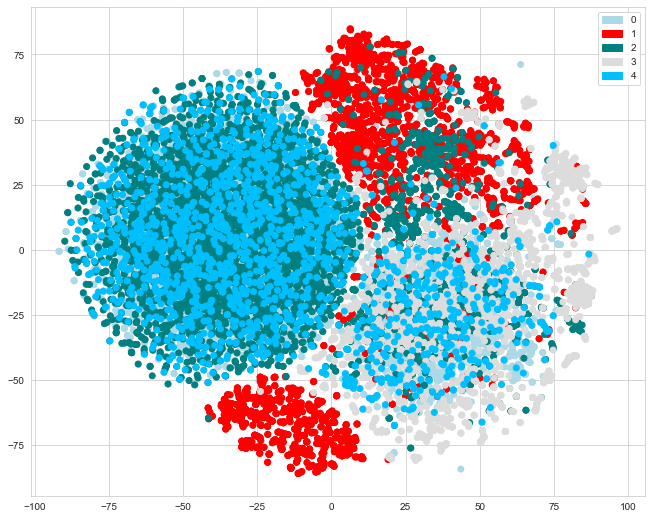

In [25]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
group_patches = [mpatches.Patch(color=color, label=team) for team, color in group_colors.items()]
ax.legend(handles=group_patches);

In [26]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [29]:
node_embeddings = (
    model.wv.vectors
)

In [47]:
node_embeddings[0]

array([ -4.368356  ,  -3.0019803 ,  13.894321  , -11.250376  ,
         6.31293   ,   2.2887385 ,   5.512743  ,  -6.5078545 ,
        -7.9575605 ,  22.173391  ,   9.921011  , -13.843304  ,
         2.676688  ,   4.9629908 ,   7.1422653 ,   4.5995603 ,
       -11.096731  ,   4.245611  ,  16.062346  ,   5.56299   ,
         7.2959714 ,   7.356485  ,  -9.360496  ,  11.651696  ,
       -19.799314  , -12.5383835 ,  12.454243  ,   3.698431  ,
         0.71768427,  18.305042  ], dtype=float32)

In [36]:
node_vectors = model.wv

In [37]:
node_vectors.save('node_vectors.kv')

In [59]:
node_vectors['40378450']

array([ 2.1745281 ,  0.9255025 ,  0.33295697, -1.2545978 , -0.2084361 ,
       -0.23708294, -0.8944652 ,  0.1432445 ,  0.4393442 , -0.42820552,
       -2.347646  , -1.1477542 , -0.1030317 , -1.4310842 , -0.21377738,
        1.1172986 ,  1.5631044 ,  1.147162  , -1.3320636 ,  0.17371145,
        0.05019066,  1.4147023 , -0.77623975, -0.6870972 , -0.7848523 ,
       -0.441326  , -3.0026245 ,  1.4496222 , -0.57941186, -1.5362774 ],
      dtype=float32)

In [41]:
outputfile = f'model_node2vec.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

Saving model in model_node2vec.gensim



In [48]:
node_embeddings.shape

(36928, 30)

In [62]:
len(node_list)

18720

In [54]:
vec_label = []
for i in range(len(node_embeddings)):
    vec_label.append()

TypeError: 'method' object is not subscriptable

In [49]:
label_df

node_id  label        color
0      12828558      0    lightblue
1      66779408      0    lightblue
2      38902949      0    lightblue
3      33450563      0    lightblue
4      57470294      0    lightblue
...         ...    ...          ...
18715  39790331      4  deepskyblue
18716  47870669      4  deepskyblue
18717  28485685      4  deepskyblue
18718  48611755      4  deepskyblue
18719  24384084      4  deepskyblue

[18720 rows x 3 columns]

In [ ]:

#    new_model = gensim.models.Word2Vec.load(temporary_filepath)

Split train and test

In [ ]:

# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(vec_label)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, test_size=None, seed = 10)

In [ ]:

clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

Predict

In [ ]:

y_pred = clf.predict(X_test)

Calculate accuracy

In [ ]:
accuracy_score(y_test, y_pred)

#### References

https://towardsdatascience.com/alternating-least-square-for-implicit-dataset-with-code-8e7999277f4b

http://ethen8181.github.io/machine-learning/recsys/1_ALSWR.html

https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

https://www.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/